# Analisis Sentimen Komentar YouTube

Notebook ini berisi analisis sentimen terhadap komentar YouTube menggunakan machine learning. Proses meliputi eksplorasi data, penanganan imbalance, pemodelan, dan analisis fitur.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Load Data dan Eksplorasi Awal

Memuat dataset yang sudah dipreprocessing dan memeriksa distribusi kelas sentimen.

In [21]:
df_full = pd.read_csv('data_preprocessed.csv')
df_full = df_full.dropna(subset=['teks_final', 'sentiment'])

print(f"Total Data Awal: {len(df_full)}")
print("Distribusi Kelas Awal:")
print(df_full['sentiment'].value_counts())

Total Data Awal: 1072
Distribusi Kelas Awal:
sentiment
Positif    691
Netral     202
Negatif    179
Name: count, dtype: int64


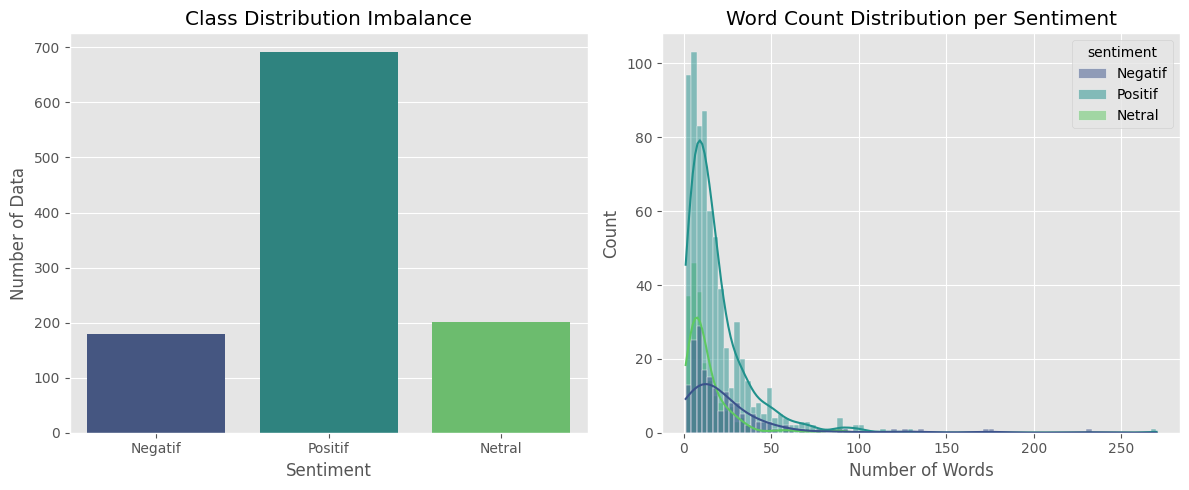

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=df_full, palette='viridis')
plt.title('Class Distribution Imbalance')
plt.xlabel('Sentiment')
plt.ylabel('Number of Data')

plt.subplot(1, 2, 2)
df_full['panjang_kata'] = df_full['teks_final'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df_full, x='panjang_kata', hue='sentiment', kde=True, palette='viridis')
plt.title('Word Count Distribution per Sentiment')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

### Word Cloud Topik Diskusi

Visualisasi kata-kata yang paling sering muncul dalam komentar secara keseluruhan.

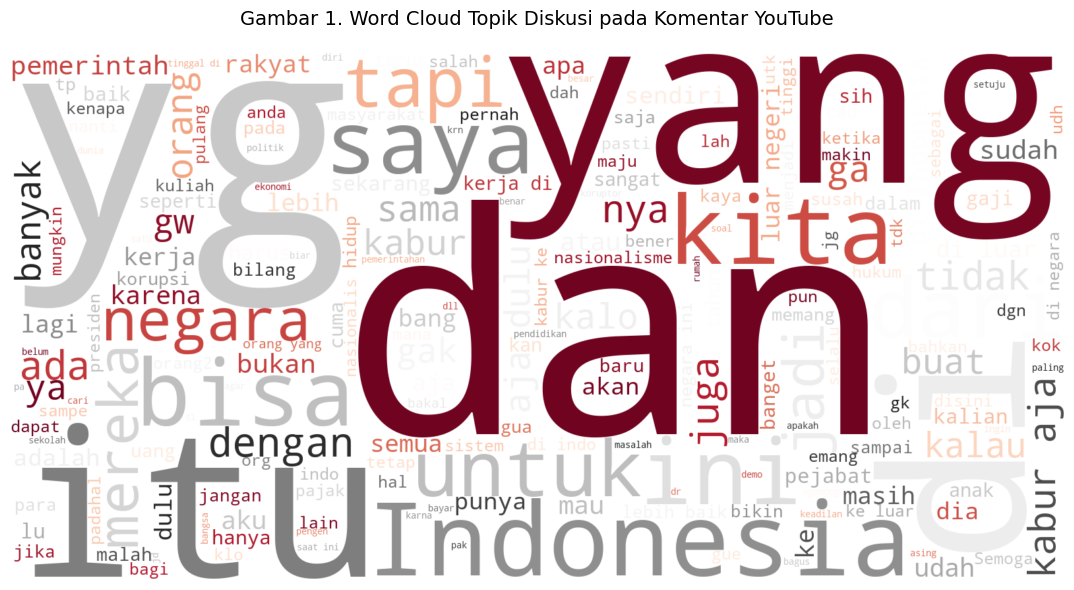

In [23]:
df = pd.read_csv('dataset_labeled.csv')

text_corpus = " ".join(comment for comment in df['Teks_Komentar'].astype(str))

wordcloud = WordCloud(width=1600, height=800,
                      background_color='white',
                      colormap='RdGy', # Merah-Abu (Nuansa serius/kritik)
                      min_font_size=10).generate(text_corpus)

# 4. Tampilkan & Simpan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Gambar 1. Word Cloud Topik Diskusi pada Komentar YouTube", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('Gambar1_WordCloud_Asli.png', dpi=300)
plt.show()

### Eksperimen: Pengaruh Kelas Netral

Membandingkan performa model dengan 3 kelas (Positif, Netral, Negatif) vs 2 kelas (Positif, Negatif) untuk menentukan strategi pemodelan yang optimal.

                      Scenario  Accuracy  F1-Score
0     3 Classes (With Neutral)  0.572093  0.569509
1  2 Classes (Without Neutral)  0.718391  0.713783


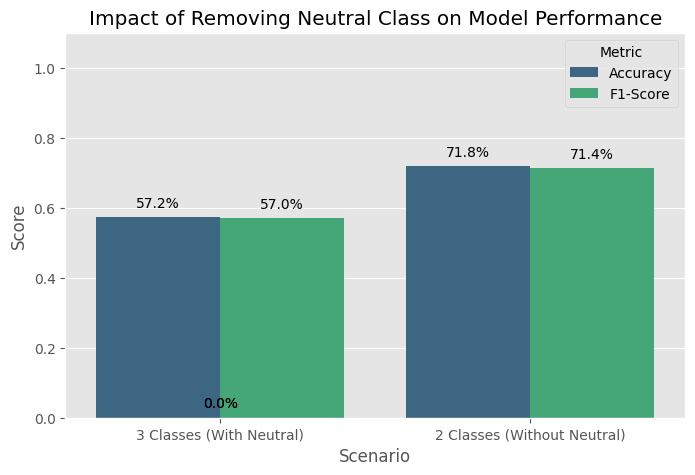

In [24]:
def run_experiment_scenario(df_input, scenario_name):
    X = df_input['teks_final']
    y = df_input['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    model = SVC(kernel='linear', class_weight='balanced')
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

acc_3, f1_3 = run_experiment_scenario(df_full, "3 Classes (Pos, Neu, Neg)")

df_2class = df_full[df_full['sentiment'] != 'Netral'].copy()
acc_2, f1_2 = run_experiment_scenario(df_2class, "2 Classes (Pos, Neg)")

results = pd.DataFrame({
    'Scenario': ['3 Classes (With Neutral)', '2 Classes (Without Neutral)'],
    'Accuracy': [acc_3, acc_2],
    'F1-Score': [f1_3, f1_2]
})

print(results)

plt.figure(figsize=(8, 5))
df_melted = results.melt(id_vars='Scenario', var_name='Metric', value_name='Score')
ax = sns.barplot(x='Scenario', y='Score', hue='Metric', data=df_melted, palette='viridis')
plt.title('Impact of Removing Neutral Class on Model Performance')
plt.ylim(0, 1.1)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

### Persiapan Data untuk Modeling

Split data train-test dan vektorisasi menggunakan TF-IDF.

## Modelling

In [25]:
df = df_full[df_full['sentiment'] != 'Netral'].copy()
print(f"Menggunakan {len(df)} data (Hanya Positif & Negatif) untuk analisis utama.")

X = df['teks_final']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

print(f"Vocabulary Size: {len(vectorizer.vocabulary_)}")

Menggunakan 870 data (Hanya Positif & Negatif) untuk analisis utama.
Vocabulary Size: 5000


### Eksperimen: Undersampling

Menguji pendekatan undersampling untuk menangani ketidakseimbangan kelas. Metode ini mengurangi kelas mayoritas agar seimbang dengan kelas minoritas.

==================== EKSPERIMEN UNDERSAMPLING ====================
Data FULL (3 Kelas):
  Train: {'Positif': 552, 'Netral': 162, 'Negatif': 143}
  Test : {'Positif': 139, 'Netral': 40, 'Negatif': 36}

Data Train Asli   : (857, 5000)
Data Train Potong : (429, 5000) (Info hilang banyak!)
Distribusi Setelah Undersampling: {'Negatif': 143, 'Netral': 143, 'Positif': 143}

--- Hasil Model Undersampling (3 Kelas: Pos, Net, Neg) ---
              precision    recall  f1-score   support

     Negatif       0.33      0.61      0.43        36
      Netral       0.27      0.40      0.32        40
     Positif       0.76      0.49      0.60       139

    accuracy                           0.49       215
   macro avg       0.45      0.50      0.45       215
weighted avg       0.60      0.49      0.52       215



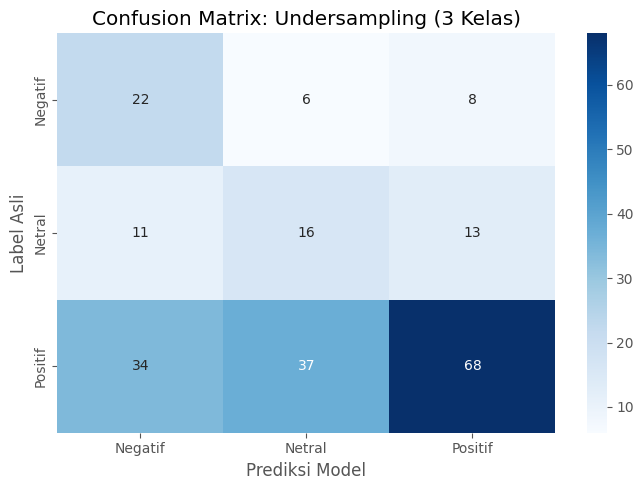

In [26]:
from imblearn.under_sampling import RandomUnderSampler

print(f"{'='*20} EKSPERIMEN UNDERSAMPLING {'='*20}")

X_full = df_full['teks_final']
y_full = df_full['sentiment']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

vectorizer_full = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_full_vect = vectorizer_full.fit_transform(X_train_full)
X_test_full_vect = vectorizer_full.transform(X_test_full)

print(f"Data FULL (3 Kelas):")
print(f"  Train: {y_train_full.value_counts().to_dict()}")
print(f"  Test : {y_test_full.value_counts().to_dict()}")

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_full_vect, y_train_full)

print(f"\nData Train Asli   : {X_train_full_vect.shape}") 
print(f"Data Train Potong : {X_train_rus.shape} (Info hilang banyak!)")
print(f"Distribusi Setelah Undersampling: {pd.Series(y_train_rus).value_counts().to_dict()}")

model_rus = SVC(kernel='linear')
model_rus.fit(X_train_rus, y_train_rus)

y_pred_rus = model_rus.predict(X_test_full_vect)
print("\n--- Hasil Model Undersampling (3 Kelas: Pos, Net, Neg) ---")
print(classification_report(y_test_full, y_pred_rus))

cm_rus = confusion_matrix(y_test_full, y_pred_rus)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_rus, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negatif', 'Netral', 'Positif'], 
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title('Confusion Matrix: Undersampling (3 Kelas)')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi Model')
plt.tight_layout()
plt.show()

### Perbandingan Model: Naive Bayes vs SVM

Membandingkan performa dua algoritma klasifikasi untuk analisis sentimen.


==================== Naive Bayes ====================
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        36
     Positif       0.79      1.00      0.88       138

    accuracy                           0.79       174
   macro avg       0.40      0.50      0.44       174
weighted avg       0.63      0.79      0.70       174


==================== SVM (Balanced) ====================
              precision    recall  f1-score   support

     Negatif       0.34      0.33      0.34        36
     Positif       0.83      0.83      0.83       138

    accuracy                           0.73       174
   macro avg       0.59      0.58      0.58       174
weighted avg       0.73      0.73      0.73       174



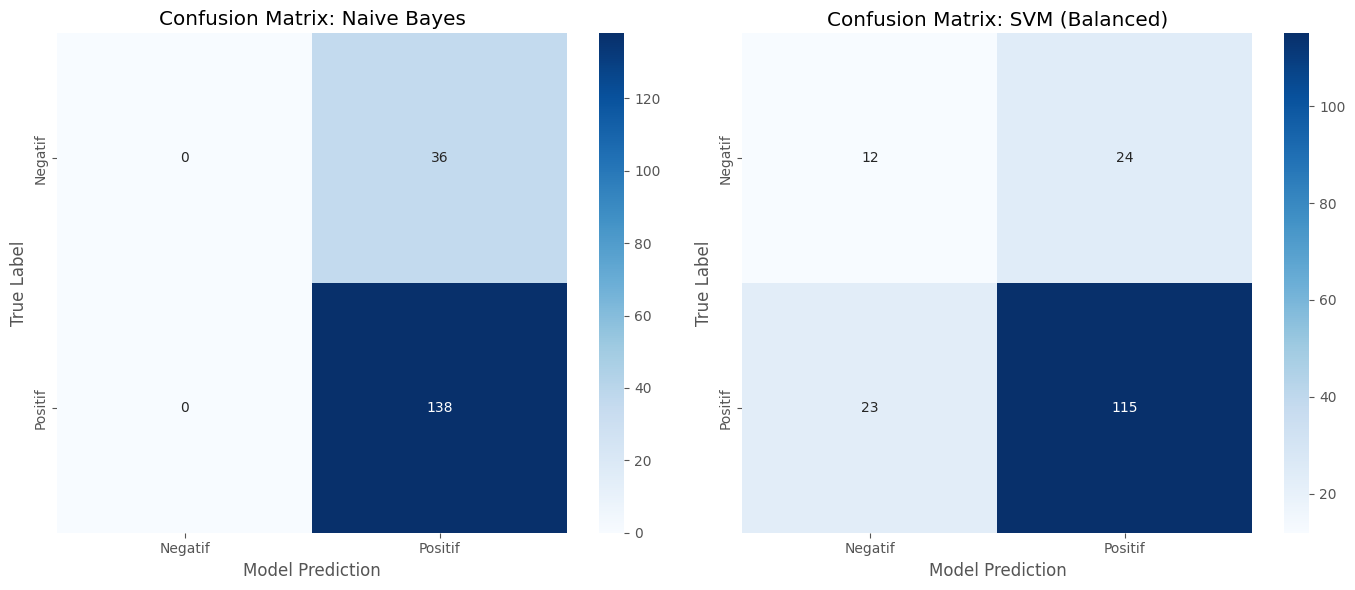

In [27]:
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (Balanced)": SVC(kernel='linear', class_weight='balanced')
}

plt.figure(figsize=(14, 6))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    
    print(f"\n{'='*20} {name} {'='*20}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Model Prediction')

plt.tight_layout()
plt.show()


FEATURE SEPARATION: 1-GRAM vs BIGRAM

📊 Total Features:
   - 1-gram: 1936
   - Bigram: 3064


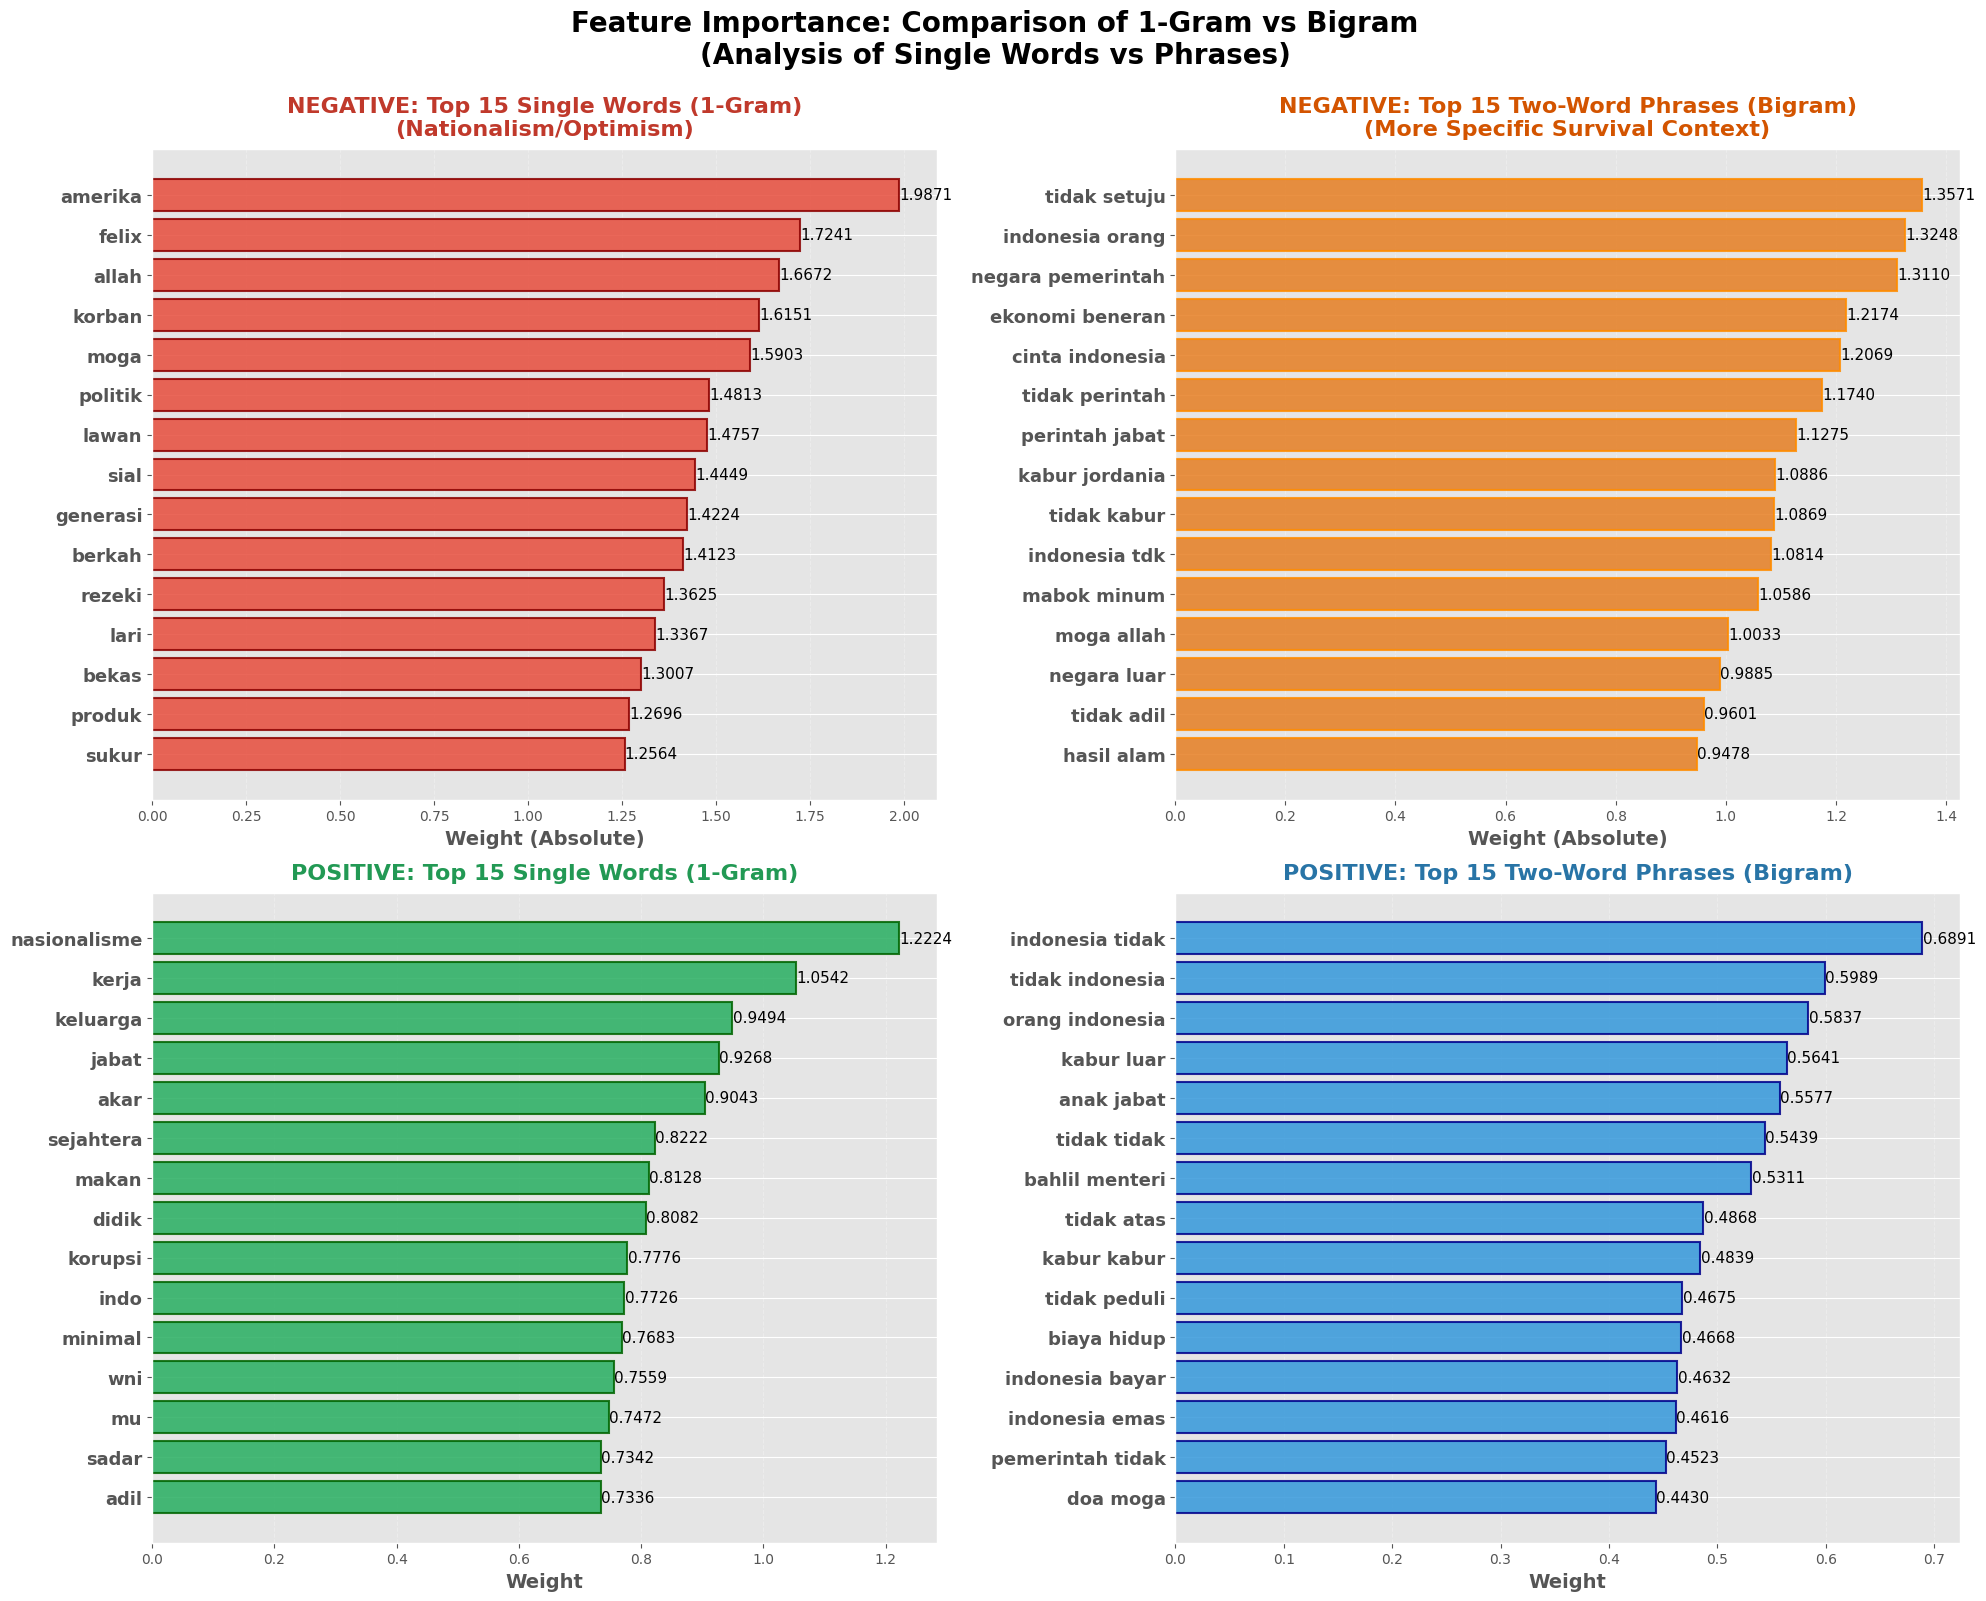


📊 TOP 5 SUMMARY:

🔴 NEGATIVE 1-GRAM:
   amerika              → -1.9871
   felix                → -1.7241
   allah                → -1.6672
   korban               → -1.6151
   moga                 → -1.5903

🟠 NEGATIVE BIGRAM:
   tidak setuju              → -1.3571
   indonesia orang           → -1.3248
   negara pemerintah         → -1.3110
   ekonomi beneran           → -1.2174
   cinta indonesia           → -1.2069

🟢 POSITIVE 1-GRAM:
   nasionalisme         → 1.2224
   kerja                → 1.0542
   keluarga             → 0.9494
   jabat                → 0.9268
   akar                 → 0.9043

🔵 POSITIVE BIGRAM:
   indonesia tidak           → 0.6891
   tidak indonesia           → 0.5989
   orang indonesia           → 0.5837
   kabur luar                → 0.5641
   anak jabat                → 0.5577


In [36]:
print(f"\n{'='*60}")
print("FEATURE SEPARATION: 1-GRAM vs BIGRAM")
print(f"{'='*60}")

model_svm = models["SVM (Balanced)"]
feature_names = vectorizer.get_feature_names_out()
coefs = model_svm.coef_.toarray()[0]

df_features = pd.DataFrame({'word': feature_names, 'weight': coefs})

df_features['n_gram_type'] = df_features['word'].apply(lambda x: '1-gram' if ' ' not in x else 'bigram')
df_1gram = df_features[df_features['n_gram_type'] == '1-gram']
df_bigram = df_features[df_features['n_gram_type'] == 'bigram']

print(f"\n📊 Total Features:")
print(f"   - 1-gram: {len(df_1gram)}")
print(f"   - Bigram: {len(df_bigram)}")

top_neg_1gram = df_1gram.nsmallest(15, 'weight')
top_neg_bigram = df_bigram.nsmallest(15, 'weight')
top_pos_1gram = df_1gram.nlargest(15, 'weight')
top_pos_bigram = df_bigram.nlargest(15, 'weight')

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

axes[0, 0].barh(range(len(top_neg_1gram)), top_neg_1gram['weight'].abs(), 
                color='#e74c3c', alpha=0.85, edgecolor='darkred', linewidth=1.5)
axes[0, 0].set_yticks(range(len(top_neg_1gram)))
axes[0, 0].set_yticklabels(top_neg_1gram['word'], fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Weight (Absolute)', fontweight='bold', fontsize=14)
axes[0, 0].set_title('NEGATIVE: Top 15 Single Words (1-Gram)\n(Nationalism/Optimism)', 
                     fontweight='bold', fontsize=16, color='#c0392b', pad=10)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(top_neg_1gram['weight'].abs()):
    axes[0, 0].text(v + 0.0005, i, f'{v:.4f}', va='center', fontsize=11)

axes[0, 1].barh(range(len(top_neg_bigram)), top_neg_bigram['weight'].abs(), 
                color='#e67e22', alpha=0.85, edgecolor='darkorange', linewidth=1.5)
axes[0, 1].set_yticks(range(len(top_neg_bigram)))
axes[0, 1].set_yticklabels(top_neg_bigram['word'], fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Weight (Absolute)', fontweight='bold', fontsize=14)
axes[0, 1].set_title('NEGATIVE: Top 15 Two-Word Phrases (Bigram)\n(More Specific Survival Context)', 
                     fontweight='bold', fontsize=16, color='#d35400', pad=10)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(top_neg_bigram['weight'].abs()):
    axes[0, 1].text(v + 0.0005, i, f'{v:.4f}', va='center', fontsize=11)

axes[1, 0].barh(range(len(top_pos_1gram)), top_pos_1gram['weight'], 
                color='#27ae60', alpha=0.85, edgecolor='darkgreen', linewidth=1.5)
axes[1, 0].set_yticks(range(len(top_pos_1gram)))
axes[1, 0].set_yticklabels(top_pos_1gram['word'], fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Weight', fontweight='bold', fontsize=14)
axes[1, 0].set_title('POSITIVE: Top 15 Single Words (1-Gram)', 
                     fontweight='bold', fontsize=16, color='#229954', pad=10)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(top_pos_1gram['weight']):
    axes[1, 0].text(v + 0.0005, i, f'{v:.4f}', va='center', fontsize=11)

axes[1, 1].barh(range(len(top_pos_bigram)), top_pos_bigram['weight'], 
                color='#3498db', alpha=0.85, edgecolor='darkblue', linewidth=1.5)
axes[1, 1].set_yticks(range(len(top_pos_bigram)))
axes[1, 1].set_yticklabels(top_pos_bigram['word'], fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Weight', fontweight='bold', fontsize=14)
axes[1, 1].set_title('POSITIVE: Top 15 Two-Word Phrases (Bigram)', 
                     fontweight='bold', fontsize=16, color='#2874a6', pad=10)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(top_pos_bigram['weight']):
    axes[1, 1].text(v + 0.0005, i, f'{v:.4f}', va='center', fontsize=11)

plt.suptitle('Feature Importance: Comparison of 1-Gram vs Bigram\n(Analysis of Single Words vs Phrases)', 
             fontsize=20, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n📊 TOP 5 SUMMARY:")
print("\n🔴 NEGATIVE 1-GRAM:")
for idx, row in top_neg_1gram.head(5).iterrows():
    print(f"   {row['word']:20s} → {row['weight']:.4f}")
    
print("\n🟠 NEGATIVE BIGRAM:")
for idx, row in top_neg_bigram.head(5).iterrows():
    print(f"   {row['word']:25s} → {row['weight']:.4f}")
    
print("\n🟢 POSITIVE 1-GRAM:")
for idx, row in top_pos_1gram.head(5).iterrows():
    print(f"   {row['word']:20s} → {row['weight']:.4f}")
    
print("\n🔵 POSITIVE BIGRAM:")
for idx, row in top_pos_bigram.head(5).iterrows():
    print(f"   {row['word']:25s} → {row['weight']:.4f}")

### Eksperimen: SMOTE vs Class Weighting

Membandingkan dua pendekatan untuk menangani imbalance:
- Class Weighting: Menyesuaikan bobot kelas di level algoritma
- SMOTE: Menambah data sintetis untuk kelas minoritas

In [ ]:
from imblearn.over_sampling import SMOTE

print(f"{'='*20} EKSPERIMEN HANDLING IMBALANCE {'='*20}")

print("\n--- Model A: SVM dengan Class Weight (Algorithmic Level) ---")
model_a = SVC(kernel='linear', class_weight='balanced')
model_a.fit(X_train_vect, y_train)
y_pred_a = model_a.predict(X_test_vect)
print(classification_report(y_test, y_pred_a))

print("\n--- Model B: SVM dengan SMOTE (Data Level) ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vect, y_train)

print(f"Data Train Asli: {X_train_vect.shape}")
print(f"Data Train SMOTE: {X_train_smote.shape} (Sudah seimbang)")

model_b = SVC(kernel='linear')
model_b.fit(X_train_smote, y_train_smote)
y_pred_b = model_b.predict(X_test_vect)
print(classification_report(y_test, y_pred_b))

==================== EKSPERIMEN HANDLING IMBALANCE ====================

--- Model A: SVM dengan Class Weight (Algorithmic Level) ---
              precision    recall  f1-score   support

     Negatif       0.34      0.33      0.34        36
     Positif       0.83      0.83      0.83       138

    accuracy                           0.73       174
   macro avg       0.59      0.58      0.58       174
weighted avg       0.73      0.73      0.73       174


--- Model B: SVM dengan SMOTE (Data Level) ---
Data Train Asli: (696, 5000)
Data Train SMOTE: (1106, 5000) (Sudah seimbang)
              precision    recall  f1-score   support

     Negatif       0.42      0.28      0.33        36
     Positif       0.83      0.90      0.86       138

    accuracy                           0.77       174
   macro avg       0.62      0.59      0.60       174
weighted avg       0.74      0.77      0.75       174



## Analisis Feature Importance

Mengidentifikasi kata-kata kunci yang paling berpengaruh dalam menentukan sentimen positif dan negatif berdasarkan bobot SVM.

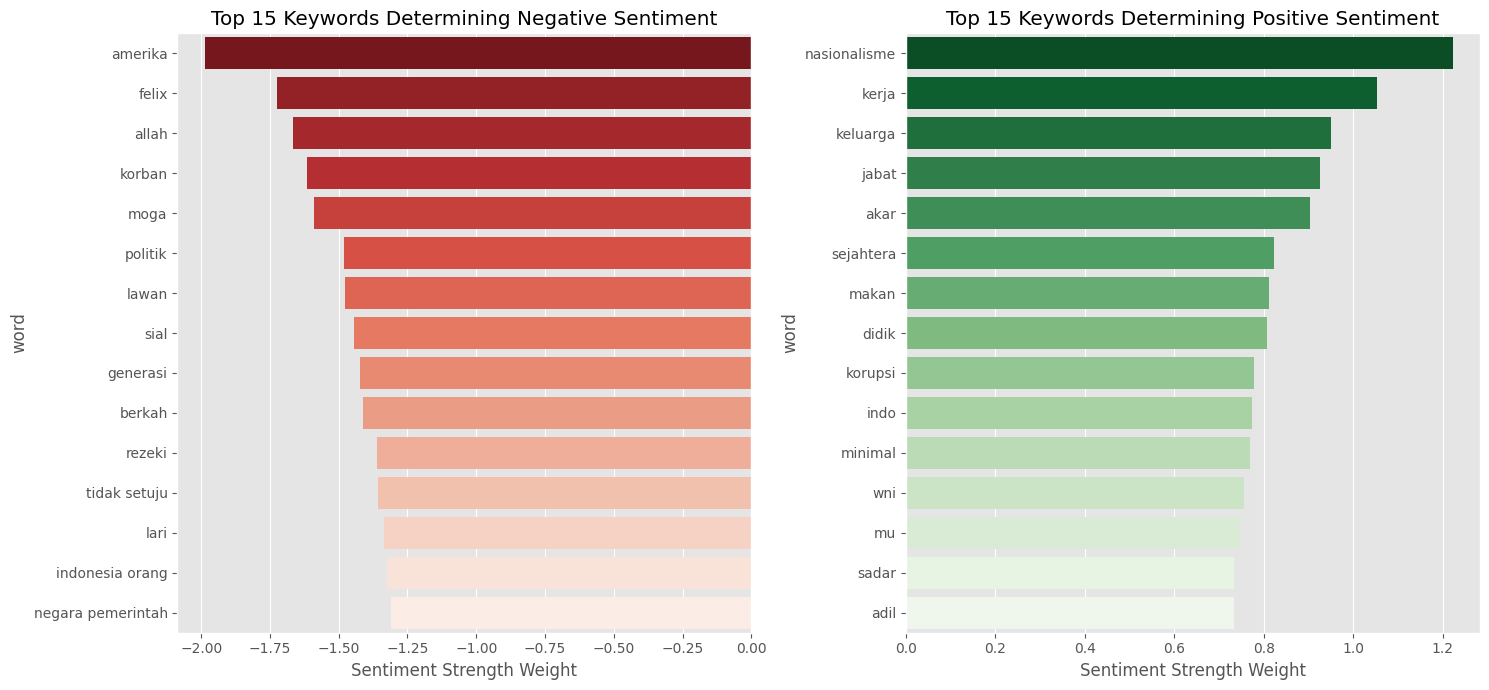

Top Negative Words: ['amerika', 'felix', 'allah', 'korban', 'moga', 'politik', 'lawan', 'sial', 'generasi', 'berkah', 'rezeki', 'tidak setuju', 'lari', 'indonesia orang', 'negara pemerintah']
Top Positive Words: ['nasionalisme', 'kerja', 'keluarga', 'jabat', 'akar', 'sejahtera', 'makan', 'didik', 'korupsi', 'indo', 'minimal', 'wni', 'mu', 'sadar', 'adil']


In [30]:
model_svm = models["SVM (Balanced)"]
feature_names = vectorizer.get_feature_names_out()
coefs = model_svm.coef_.toarray()[0]

df_features = pd.DataFrame({'word': feature_names, 'weight': coefs})

top_neg = df_features.sort_values(by='weight', ascending=True).head(15)
top_pos = df_features.sort_values(by='weight', ascending=False).head(15)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(data=top_neg, x='weight', y='word', palette='Reds_r')
plt.title('Top 15 Keywords Determining Negative Sentiment')
plt.xlabel('Sentiment Strength Weight')

plt.subplot(1, 2, 2)
sns.barplot(data=top_pos, x='weight', y='word', palette='Greens_r')
plt.title('Top 15 Keywords Determining Positive Sentiment')
plt.xlabel('Sentiment Strength Weight')

plt.tight_layout()
plt.show()

print("Top Negative Words:", top_neg['word'].tolist())
print("Top Positive Words:", top_pos['word'].tolist())

### Contoh Konteks Penggunaan Kata Kunci

Menampilkan contoh kalimat asli yang mengandung kata-kata kunci dari feature importance untuk memahami konteks penggunaannya.

In [32]:
def print_context_examples(df, feature_df, sentiment_target, n_keywords=5, n_examples=3):
    print(f"\n{'='*20} CONTOH KONTEKS: SENTIMEN {sentiment_target.upper()} {'='*20}")
    
    keywords = feature_df['word'].head(n_keywords).tolist()
    
    for word in keywords:
        matches = df[
            (df['teks_final'].str.contains(word, na=False)) & 
            (df['sentiment'] == sentiment_target)
        ]
        
        print(f"\n[Fitur/Kata: '{word}'] (Ditemukan di {len(matches)} data)")
        
        if len(matches) > 0:
            samples = matches['Teks_Komentar'].sample(min(n_examples, len(matches)), random_state=42).tolist()
            for i, text in enumerate(samples):
                clean_text = text.replace('\n', ' ').strip()
                print(f"  {i+1}. \"{clean_text[:100]}...\"")
        else:
            print("  - Tidak ada contoh kalimat yang ditemukan.")

print_context_examples(df, top_neg, 'Negatif', n_keywords=5)
print_context_examples(df, top_pos, 'Positif', n_keywords=5)


==================== CONTOH KONTEKS: SENTIMEN NEGATIF ====================

[Fitur/Kata: 'amerika'] (Ditemukan di 7 data)
  1. "Kabur aja kalian semua dari pada bikin semak, lebih baik kalan kabur ke Amerika sono atau Eropa..."
  2. "GPP kabur aja dulu, asal di negara orang itu  lu kerja bener, dan kuat mental ketika disuru bayar TA..."
  3. "Kabur aja dulu itu hastag nya buzzer wkwkwkwk kabur aja dulu, lah lu enak punya akses, emang lu TKI...."

[Fitur/Kata: 'felix'] (Ditemukan di 15 data)
  1. "saya selalu bilang ke anak saya yg sekarang kelas 7smp kamu sekolah /kuliah /kerja di sini aja janga..."
  2. "Ko Raymond dan Ust Felix adalah 2 orang hebat di Indonesia diskusi tingkat dewa. Bismillah sukses un..."
  3. "Sistem tidak berjalan dengan baik ditambah oknum,  Tidak bisa ganti sistem,  Edukasi di ring luar da..."

[Fitur/Kata: 'allah'] (Ditemukan di 15 data)
  1. "Wahai para kompeni2😁.. dengerin nih dialog para kesatria sejati indonesia yg sesungguhnya!.  Ustadz ..."
  2. "Semoga 

### Word Cloud Berdasarkan Bobot SVM

Visualisasi kata-kata penting berdasarkan bobot feature yang dipelajari model SVM.

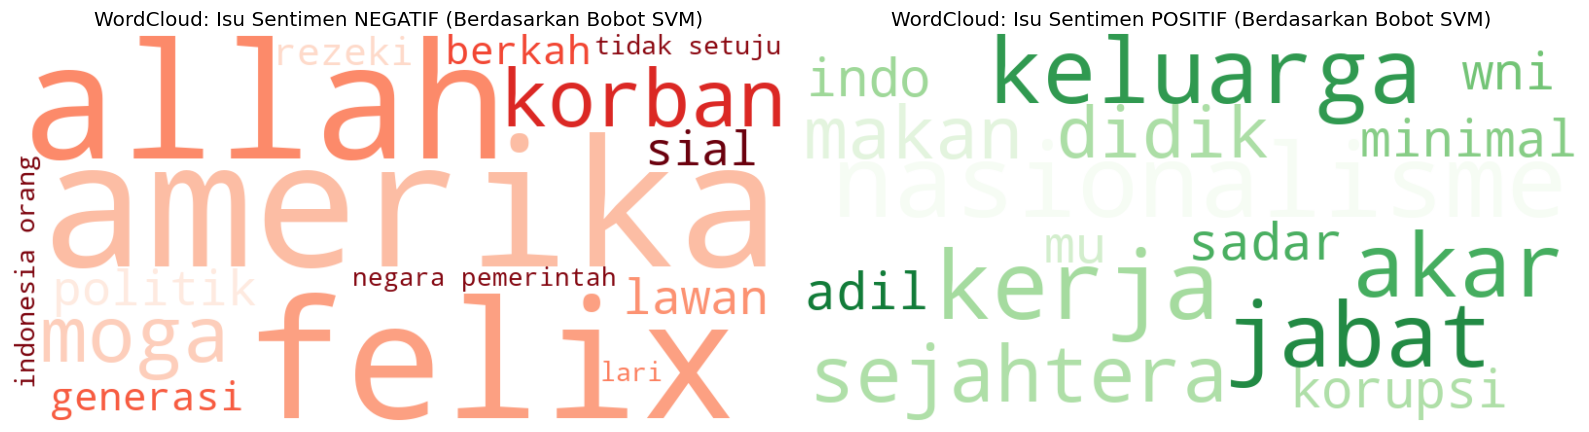

In [ ]:
from wordcloud import WordCloud

data_pos = dict(zip(top_pos['kata'], top_pos['bobot']))
data_neg = dict(zip(top_neg['kata'], top_neg['bobot'].abs()))

wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens')
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds')

wc_pos.generate_from_frequencies(data_pos)
wc_neg.generate_from_frequencies(data_neg)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('WordCloud: Isu Sentimen NEGATIF (Berdasarkan Bobot SVM)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title('WordCloud: Isu Sentimen POSITIF (Berdasarkan Bobot SVM)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df_analysis = df.copy()

model_final = models["SVM (Balanced)"] # Pastikan nama variabelnya sesuai notebook Anda

X_analysis_vect = vectorizer.transform(df_analysis['teks_final'])

scores = model_final.decision_function(X_analysis_vect)
df_analysis['confidence_score'] = scores

print(f"Label Kelas Negatif (Score < 0): {model_final.classes_[0]}")
print(f"Label Kelas Positif (Score > 0): {model_final.classes_[1]}")
print("-" * 50)

top_positive = df_analysis.nlargest(5, 'confidence_score')
top_negative = df_analysis.nsmallest(5, 'confidence_score')

print("=== TOP 5 KOMENTAR PALING POSITIF (PRO-MIGRATION/CRITICAL) ===")
for i, row in top_positive.iterrows():
    teks_tampil = row['Teks_Komentar'] if 'Teks_Komentar' in df_analysis.columns else row['teks_final']
    print(f"[Score: {row['confidence_score']:.2f}] {teks_tampil}")
    print("---")

print("\n=== TOP 5 KOMENTAR PALING NEGATIF (NATIONALIST/STAY) ===")
for i, row in top_negative.iterrows():
    teks_tampil = row['Teks_Komentar'] if 'Teks_Komentar' in df_analysis.columns else row['teks_final']
    print(f"[Score: {row['confidence_score']:.2f}] {teks_tampil}")
    print("---")

Label Kelas Negatif (Score < 0): Negatif
Label Kelas Positif (Score > 0): Positif
--------------------------------------------------
=== TOP 5 KOMENTAR PALING POSITIF (PRO-MIGRATION/CRITICAL) ===
[Score: 1.83] Yang harusnya dipertnyakan nasionalismenya itu ya pejabat-pejabat, termasuk pak bahlil itu sendiri. Kalo mereka memang punya rasa nasionalisme, harusnya mereka amanah dalam kerja kelola negara, hasilnya negara makmur masyarakat sejahtera. Lah ini sebaliknya, korupsi di mana-mana, pejabat mentingin diri sendiri dan kelompoknya. Apa itu yang mereka maksud nasionalisme?
---
[Score: 1.54] di negara sendiri keadilan gak dijamin, korupsi dimana-mana, pejabat seenaknya, pendidikan kurang berkualitas dan gak di prioritaskan, pekerjaan susah. dikit dikit pungutan,  TERUS pas pengen mendapatkan penghidupan yang layak di luar negeri malah dibilang gak nasionalis. KAN G0BL0i<  YA!
---
[Score: 1.52] Lo kaburrr,tetap aja nyari makannya di Indo
---
[Score: 1.49]  Gw tahun ini resmi lepas WNI da

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def get_log_odds(text_series, label_series):
    cv = CountVectorizer(stop_words=None, max_features=5000)
    X = cv.fit_transform(text_series)
    feature_names = cv.get_feature_names_out()
    
    pos_idx = np.where(label_series == 'Positif')[0]
    neg_idx = np.where(label_series == 'Negatif')[0]
    
    pos_counts = np.array(X[pos_idx].sum(axis=0)).flatten() + 1
    neg_counts = np.array(X[neg_idx].sum(axis=0)).flatten() + 1
    
    pos_prob = pos_counts / pos_counts.sum()
    neg_prob = neg_counts / neg_counts.sum()
    
    log_odds = np.log(pos_prob / neg_prob)
    
    return pd.DataFrame({'kata': feature_names, 'log_odds': log_odds})

df_logodds = get_log_odds(df['teks_final'], df['sentiment'])

print("=== KATA PALING KHAS DI SENTIMEN POSITIF (Scientific: High Log-Odds) ===")
print(df_logodds.nlargest(10, 'log_odds'))

print("\n=== KATA PALING KHAS DI SENTIMEN NEGATIF (Scientific: Low Log-Odds) ===")
print(df_logodds.nsmallest(10, 'log_odds'))

=== KATA PALING KHAS DI SENTIMEN POSITIF (Scientific: High Log-Odds) ===
              kata  log_odds
2717        paspor  2.352690
2198       mending  2.198539
1507         jamin  2.016218
1630        kantor  2.016218
2608          omon  2.016218
1037     fasilitas  1.873117
4039           wni  1.873117
2383  nasionalisme  1.833896
22            adik  1.793074
669     corruption  1.793074

=== KATA PALING KHAS DI SENTIMEN NEGATIF (Scientific: Low Log-Odds) ===
         kata  log_odds
396    berkah -2.483592
2125     mari -2.483592
1338    hujan -2.301270
1874   kritis -2.301270
2034     lpdp -2.301270
2065    mafia -2.301270
2080  makasih -2.301270
2808    persh -2.301270
60    akhirat -2.078127
347     bekas -2.078127
